# 1. Imports, Functions and Loading Data

## 1.1. Import

In [2]:
import random
import inflection
import math
import warnings
import pickle
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb

from scipy                 import stats as ss
from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder



## 1.2 Helper Functions

In [3]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        
        if verbose:
            print('\nKFold Number {}'.format(k))

        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfol interance
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])    
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)},
                        index=[0])

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd. DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

jupyter_settings()
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 1.3 Loading data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
35563,999,2,2015-06-30,17046,1000,1,1,0,0,d,c,15140.0,2.0,2002.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"


# 2. Data describe

## 2.1 Rename Columns

In [6]:
df1 = df_raw.copy()

In [7]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 2.2  Data Dimensions

In [10]:
print('Number of Rows {}'.format(df1.shape[0]))
print('Number of columns {}'.format(df1.shape[1]))

Number of Rows 1017209
Number of columns 18


## 2.3 Data types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 2.5 Fillout NA

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(
    lambda x: x['date'].month 
    if math.isnan(x['competition_open_since_month']) 
    else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(
    lambda x: x['date'].year 
    if math.isnan(x['competition_open_since_year']) 
    else x['competition_open_since_year'], axis=1)


#promo2_since_week
df1['promo2_since_week'] = df1.apply(
    lambda x: x['date'].week 
    if math.isnan(x['promo2_since_week']) 
    else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(
    lambda x: x['date'].year 
    if math.isnan(x['promo2_since_year']) 
    else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 
    else 1 if x['month_map'] in x['promo_interval'].split(',')
    else 0, axis=1)

In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [17]:
df1.sample(5).T

,860354,770424,615351,659299,728612
store,360,745,657,5,188
day_of_week,2,6,5,7,1
date,2013-05-21 00:00:00,2013-08-10 00:00:00,2013-12-27 00:00:00,2013-11-17 00:00:00,2013-09-16 00:00:00
sales,7083,2746,5701,0,3314
customers,862,302,854,0,332
open,1,1,1,0,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,1,0,1,0,0
store_type,a,a,c,a,d


## 2.6 Change Types

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
df1['is_promo'] = df1['is_promo'].astype(int)


## 2.7 Descriptive Statistical

In [20]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.7.1 Numerical Attributes

In [18]:
#central Tendency = mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 2.7.2 Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

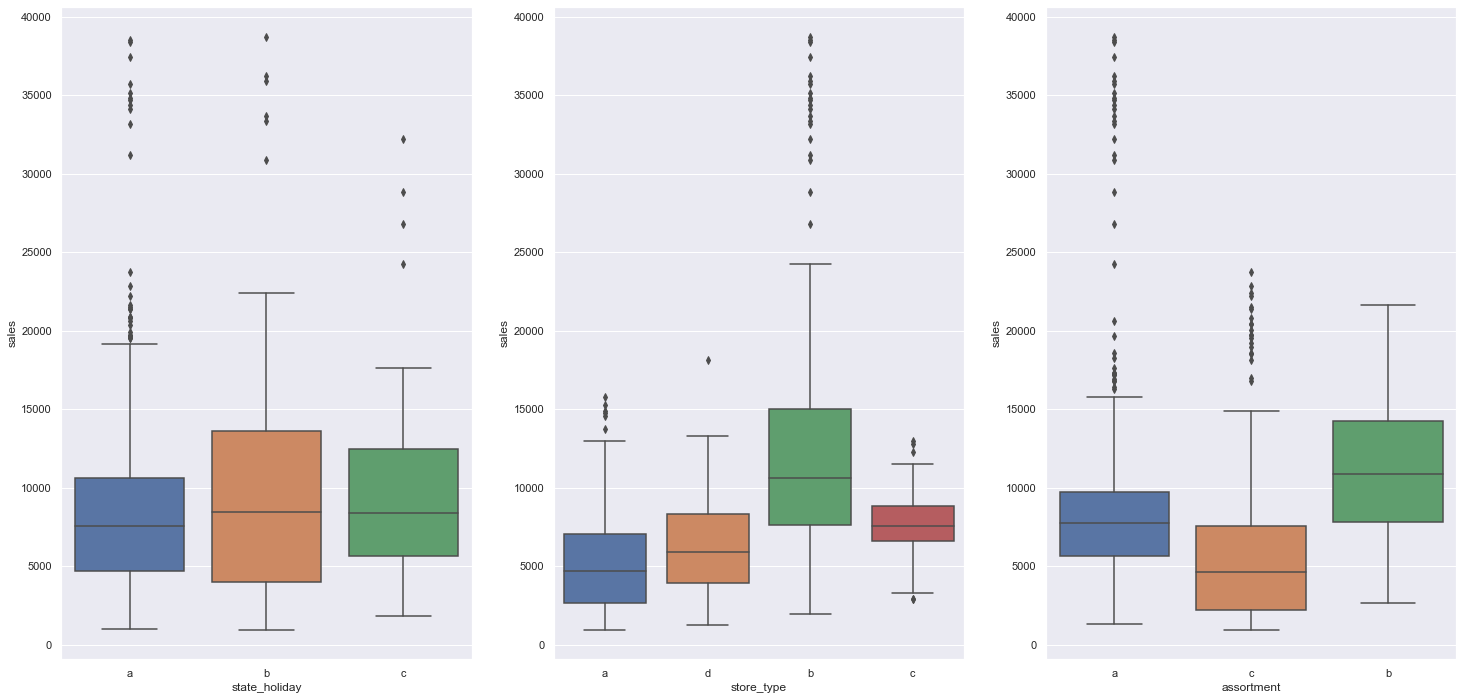

In [22]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)] 

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 3. Feature Engineering

In [21]:
df2 = df1.copy()

## 3.1 Mind Map Hypothesis

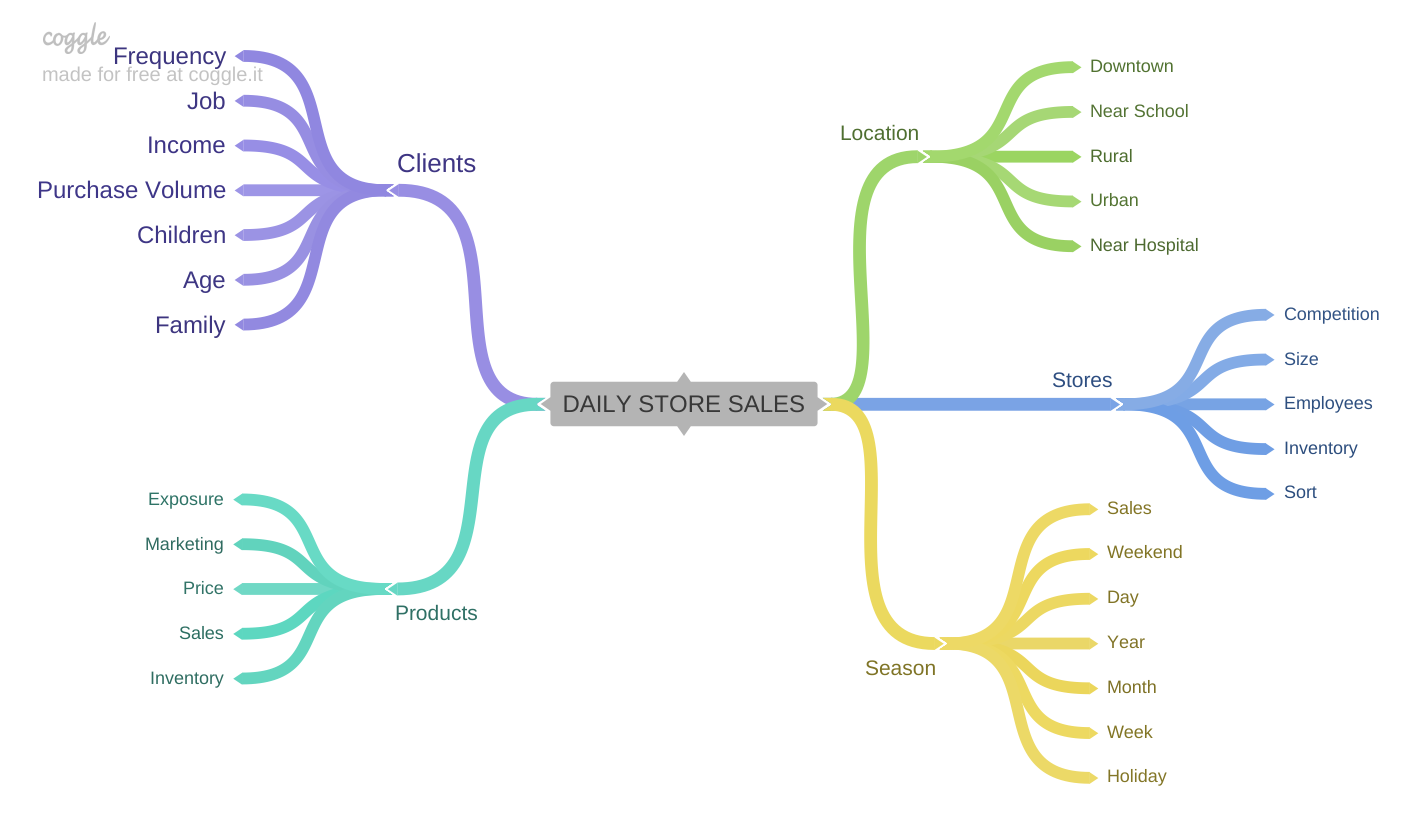

In [24]:
Image('img/MindMapHypothesis.png')

## 3.2 Hypothesis
**Hypothesis that we can suggest by analyzing the mind map.**

### 3.2.1  Store Hypothesis

**1.** Should store with more employees sell more? <br>
**2.** Should store with more inventory sell more?<br>
**3.** Should bigger stores sell more?<br>
**4.** Should smaller stores sell less?<br>
**5.** Should stores with greater assortment sell more?<br>
**6.** Should stores with closer competitors sell less?<br>
**7.** Should stores with longer competitors sell more?<br>

### 3.2.2  Product Hypothesis

**1.** Should stores that invest more in marketing sell more? <br>
**2.** Should stores that display more products sell more?<br>
**3.** Should stores that have lower prices sell more?<br>
**4.** Should stores with active promotions sell more?<br>
**5.** Should stores with more days of active promotions sell more?<br>
**6.** Should stores with more consecvutives promotions sell more?<br>

### 3.2.3  Season Hypothesis

**1.** Should stores open during Christmas sell more? <br>
**2.** Should stores sell more over the years?<br>
**3.** Should stores sell more in the second half of the year?<br>
**4.** Should stores sell more after the 10th of each month?<br>
**5.** Should stores sell less on weekends?<br>
**6.** Should stores sell less during school holidays?<br>

## 3.3 Final Hipothesis
**What we can evaluate with the data we have.**

**1.** Should stores with greater assortment sell more?<br>
**2.** Should stores with closer competitors sell less?<br>
**3.** Should stores with longer competitors sell more?<br>
**4.** Should stores with active promotions sell more?<br>
**5.** Should stores with more days of active promotions sell more?<br>
**6.** Should stores with more consecvutives promotions sell more?<br>
**7.** Should stores open during Christmas sell more? <br>
**8.** Should stores sell more over the years?<br>
**9.** Should stores sell more in the second half of the year?<br>
**10.** Should stores sell more after the 10th of each month?<br>
**11.** Should stores sell less on weekends?<br>
**12.** Should stores sell less during school holidays?<br>

## 3.4 Feature Engineering 

In [22]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [23]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 4. Variables Filter

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1 Rows filter

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 4.2 Columns selection

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3.drop(cols_drop, axis=1, inplace=True)

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 5. Data Analysis

In [29]:
df4 = df3.copy()

## 5.1 Analysis Univariate

### 5.1.1 Response variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

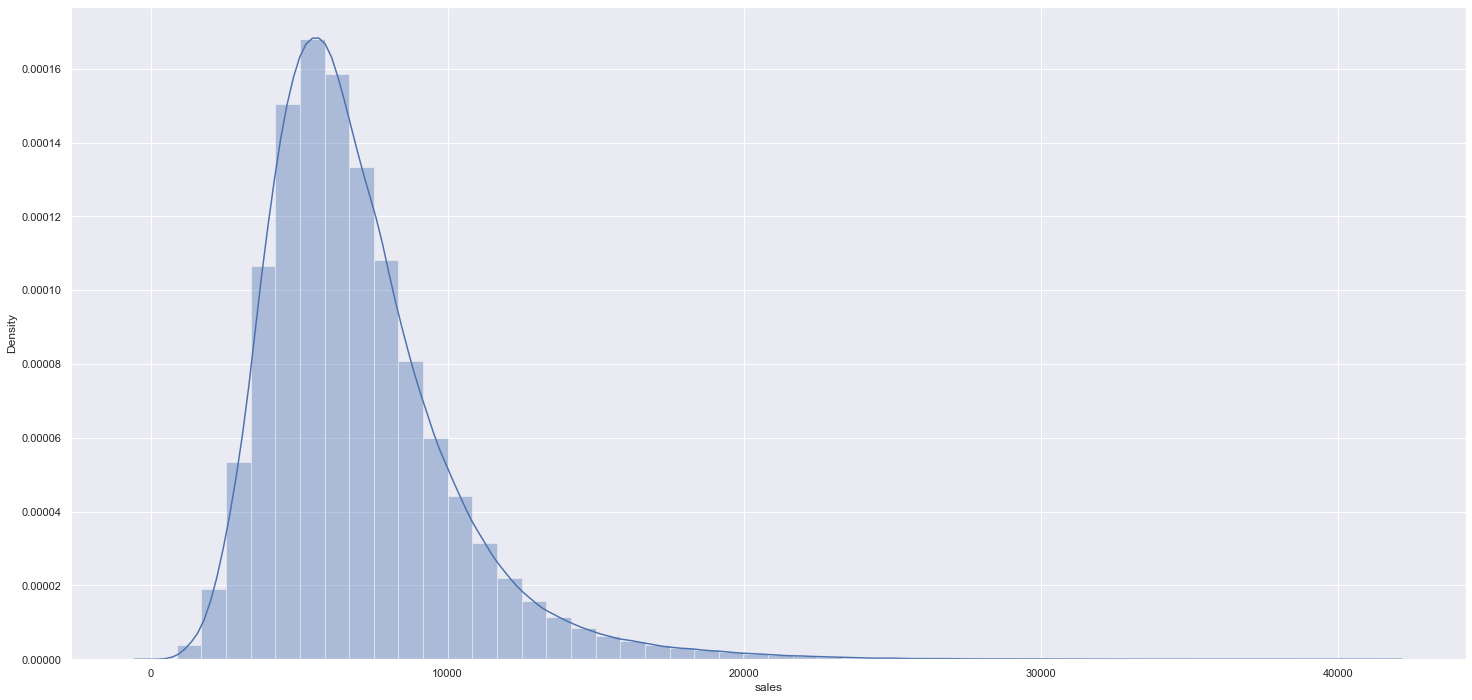

In [33]:
sns.distplot(df4['sales'])

### 5.1.2 Numerical Variable

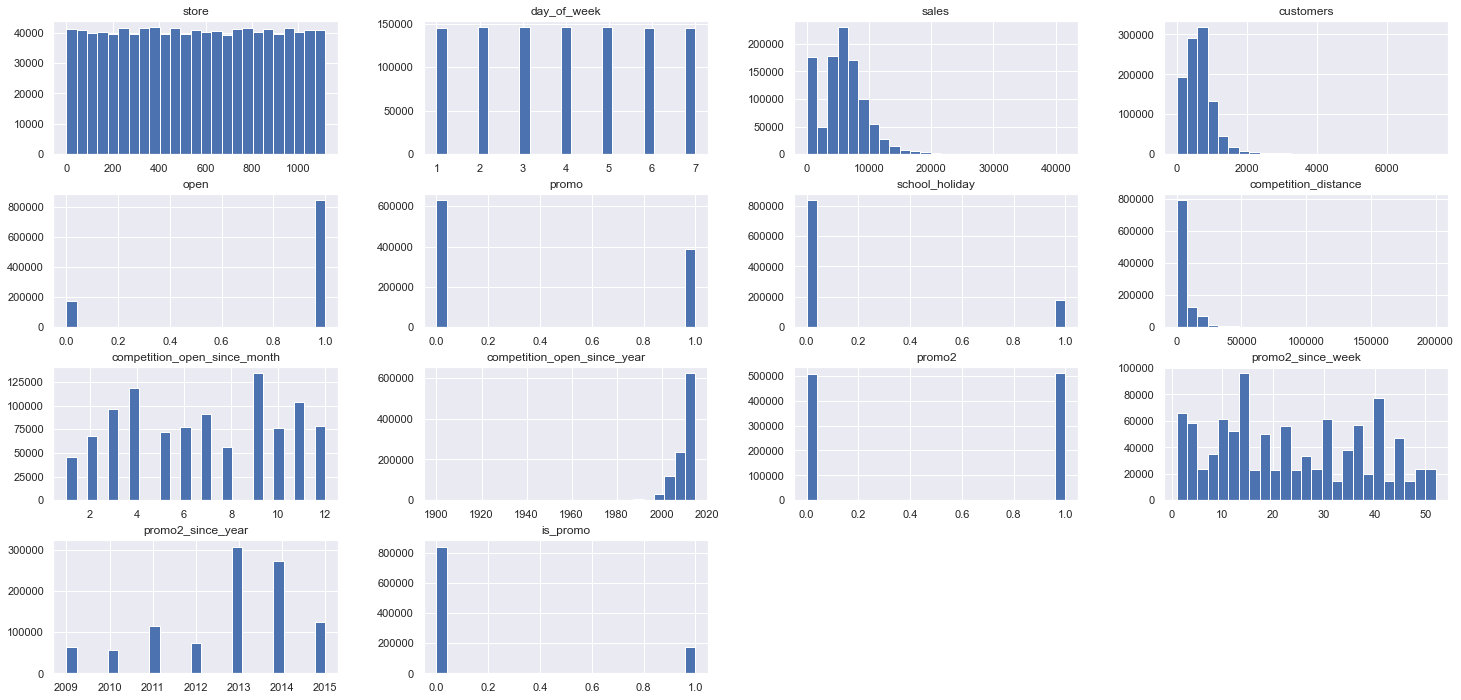

In [34]:
num_attributes.hist(bins=25);

### 5.1.3 Categorical Variable

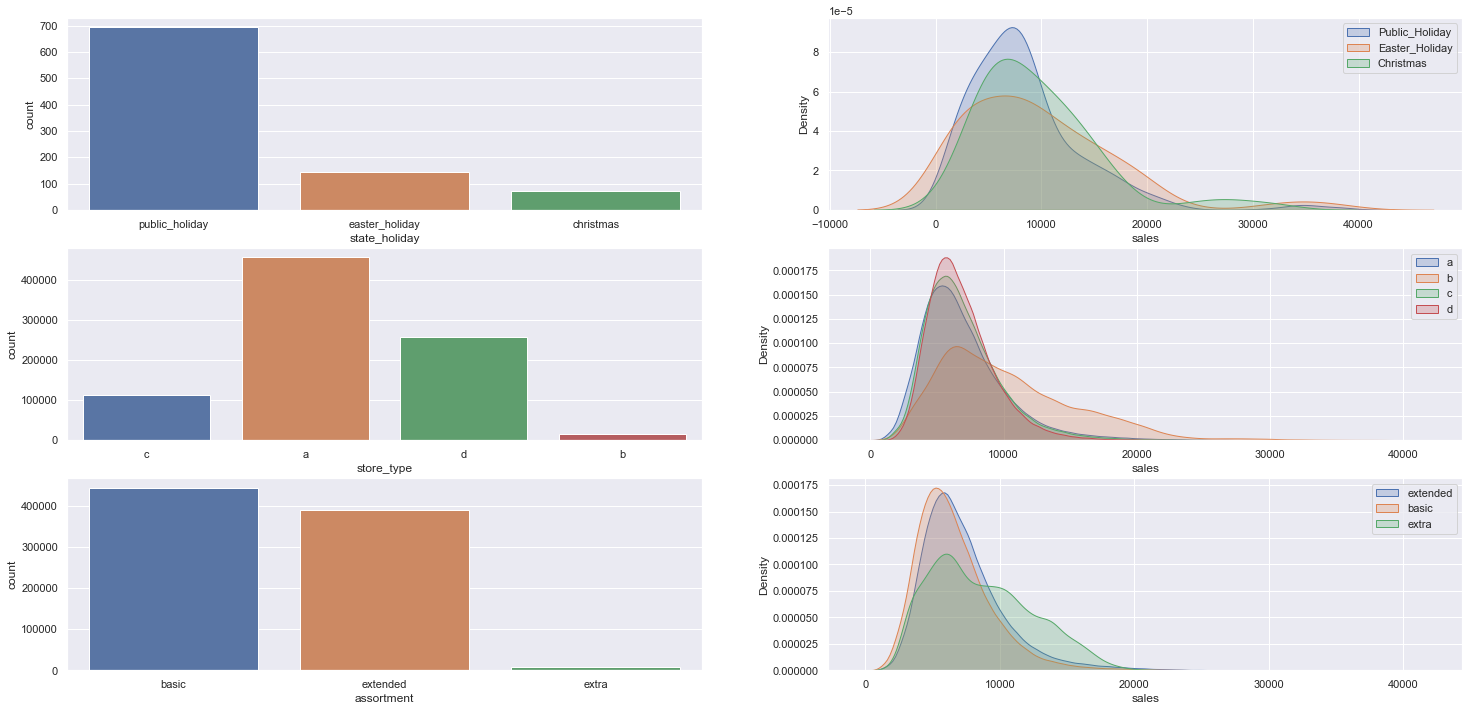

In [35]:
#state_holiday
plt.subplot(3,2,1)
no_holiday = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(no_holiday['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='Public_Holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='Easter_Holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='Christmas', shade=True)
plt.legend()

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()

## 5.2 Analysis Bivariate

### 5.2.1 H1 - Should stores with greater assortment sell more?
**False** Stores with greater assortment sells less

<AxesSubplot:xlabel='year_week'>

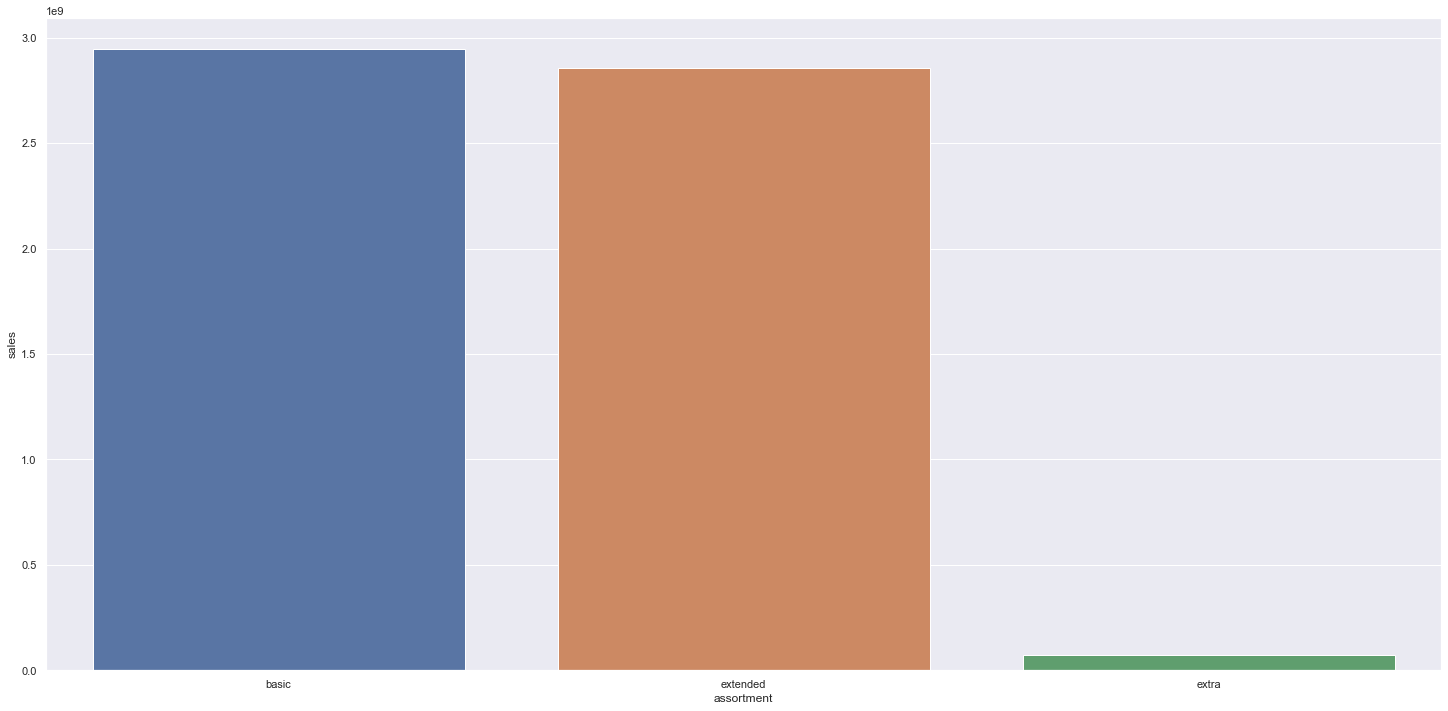

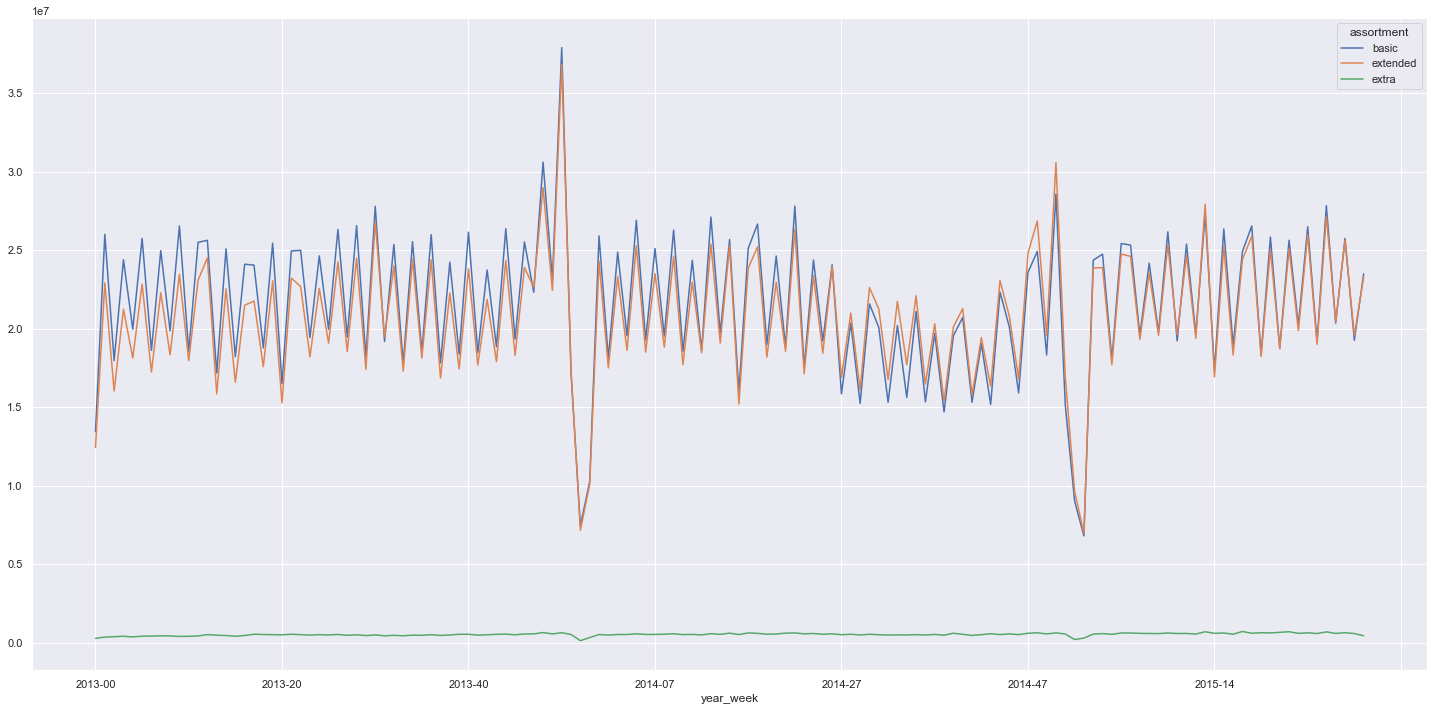

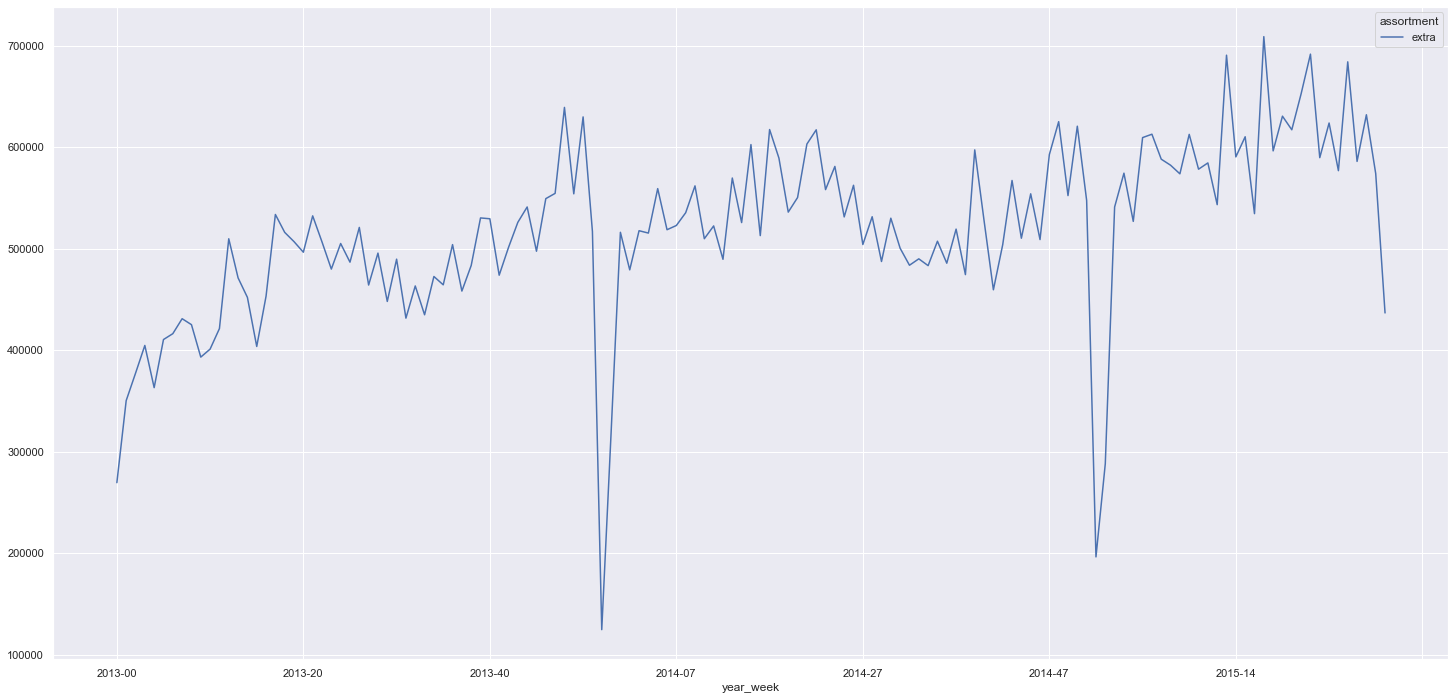

In [36]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

In [37]:
aux2 = df4[['store', 'assortment']]
aux2.drop_duplicates(subset=['store', 'assortment'], keep='last', inplace=True)
aux2['assortment'].value_counts()

basic       593
extended    513
extra         9
Name: assortment, dtype: int64

### 5.2.2 H2 - Should stores with closer competitors sell less?
***False*** Because stores with closer competitors sells more.

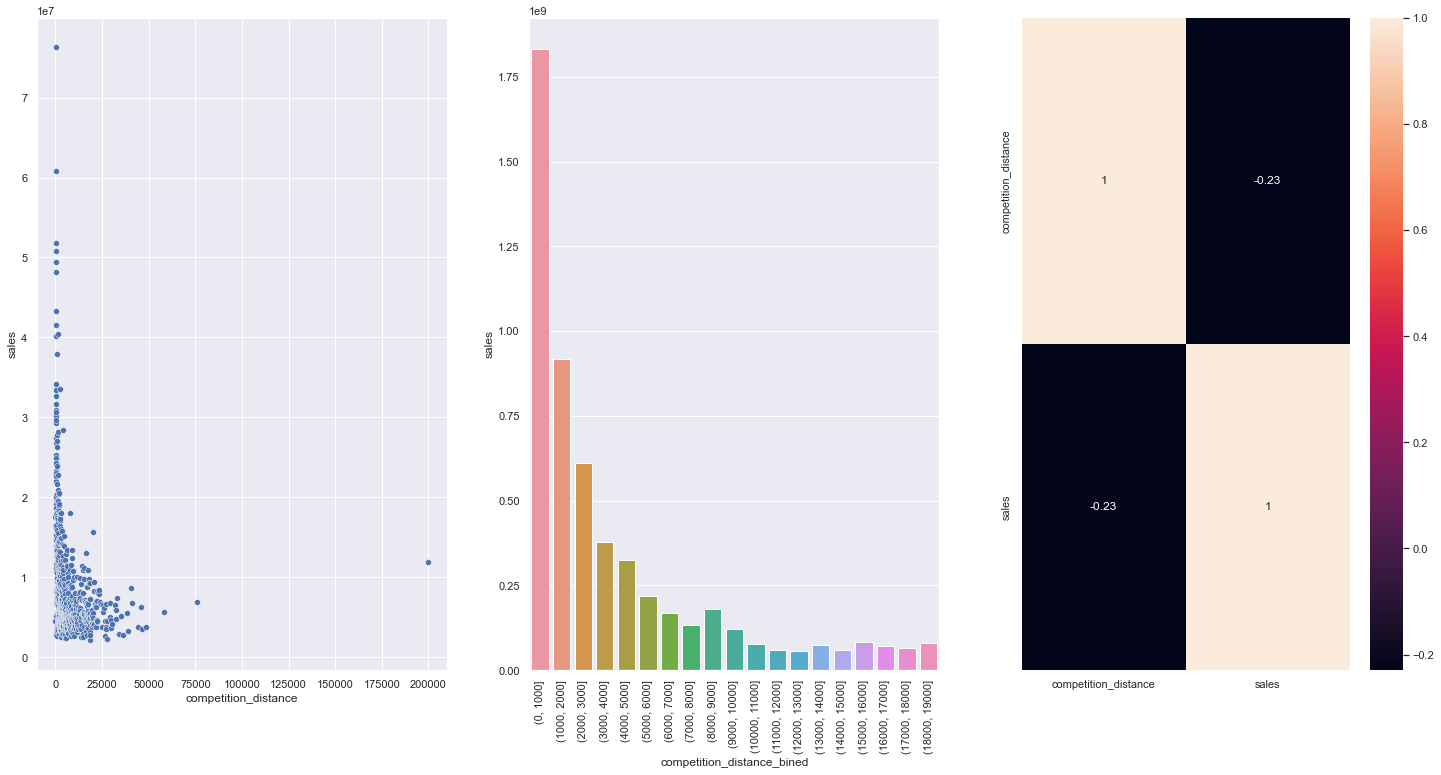

In [38]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_bined'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_bined', 'sales']].groupby('competition_distance_bined').sum().reset_index()
sns.barplot(x='competition_distance_bined', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 5.2.3 H3 - Should stores with longer competitors sell more?
**False** Because stores with longer competitors sells less.

<AxesSubplot:>

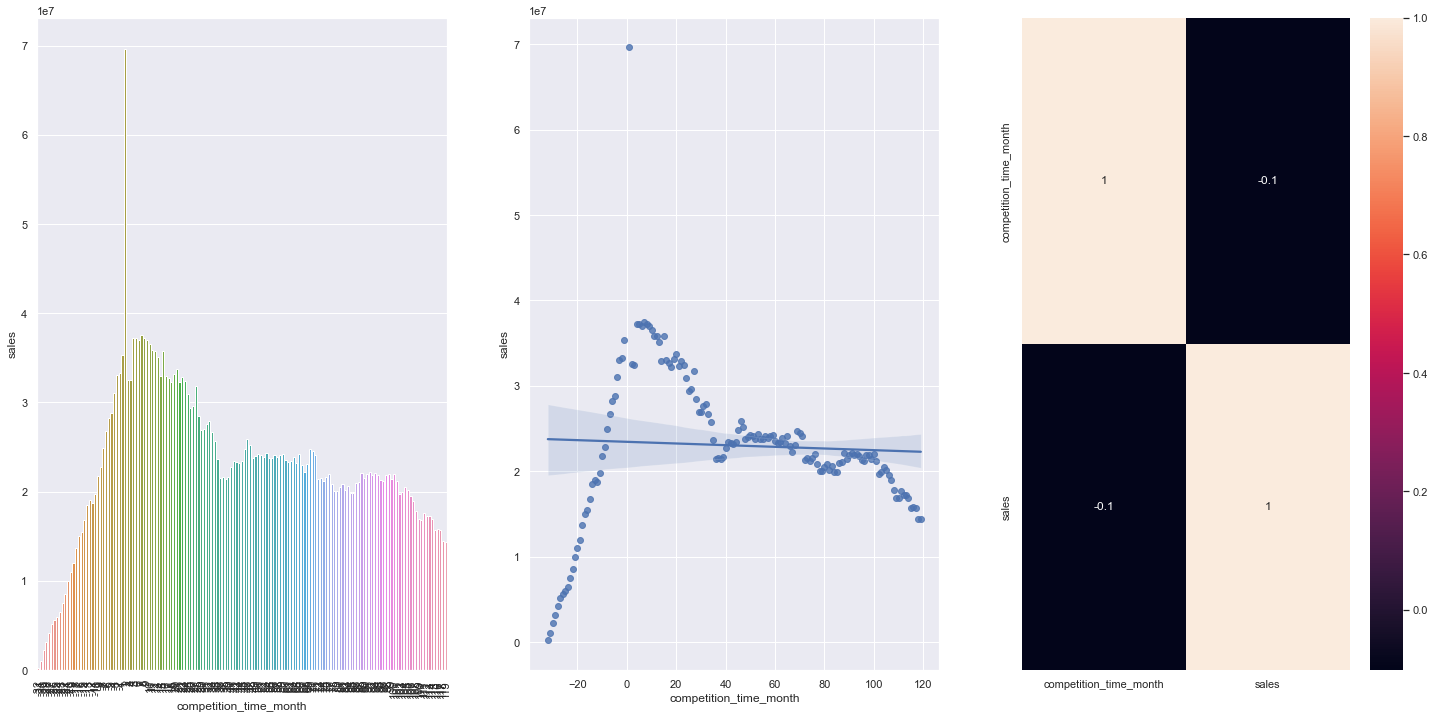

In [39]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.subplot(1,3,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 5.2.4 H4 - Should stores with active promotions sell more?
**False** Because stres with active promotions sells less after a time period.

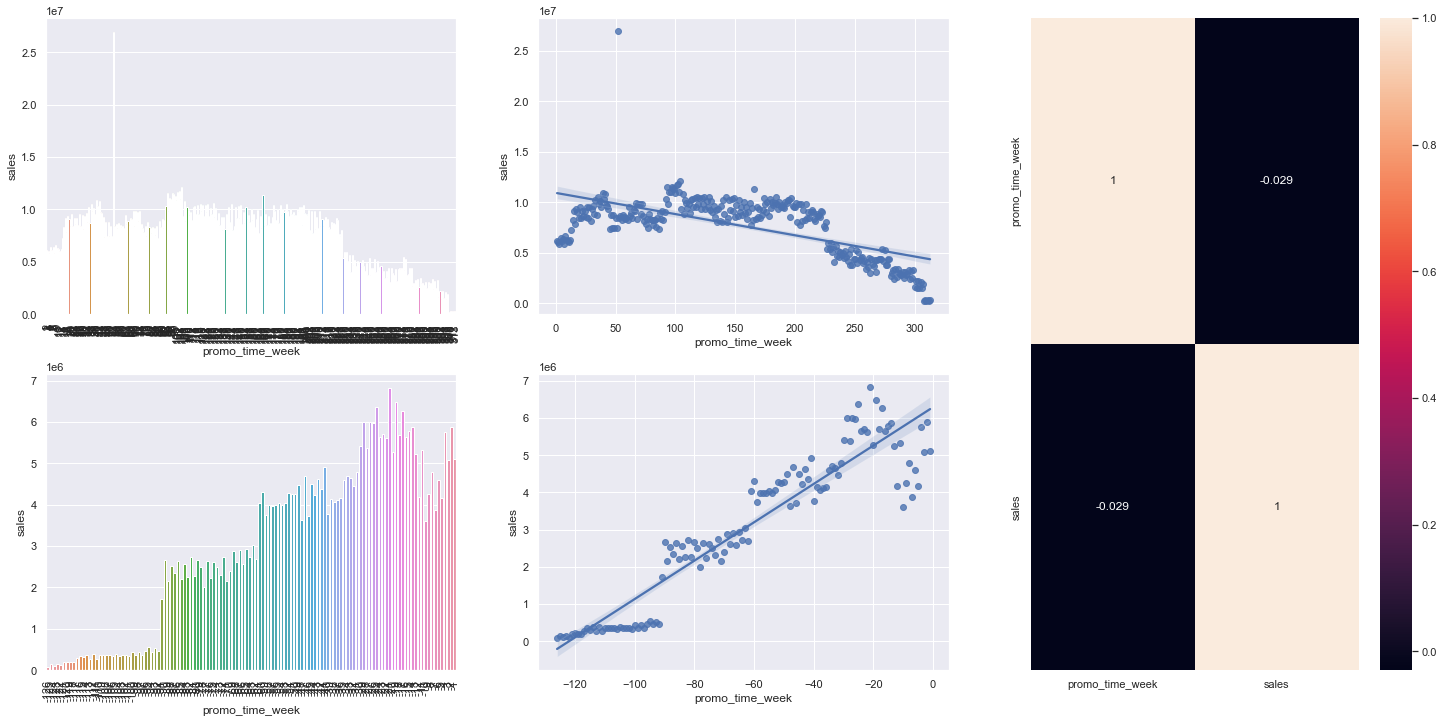

In [40]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extended
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 5.2.5 <s>H5 - Should stores with more days of active promotions sell more?</s>

### 5.2.6 H6 - Should stores with more consecvutives promotions sell more?
**False** Because stores with more consecutives promotions sells less.

In [41]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


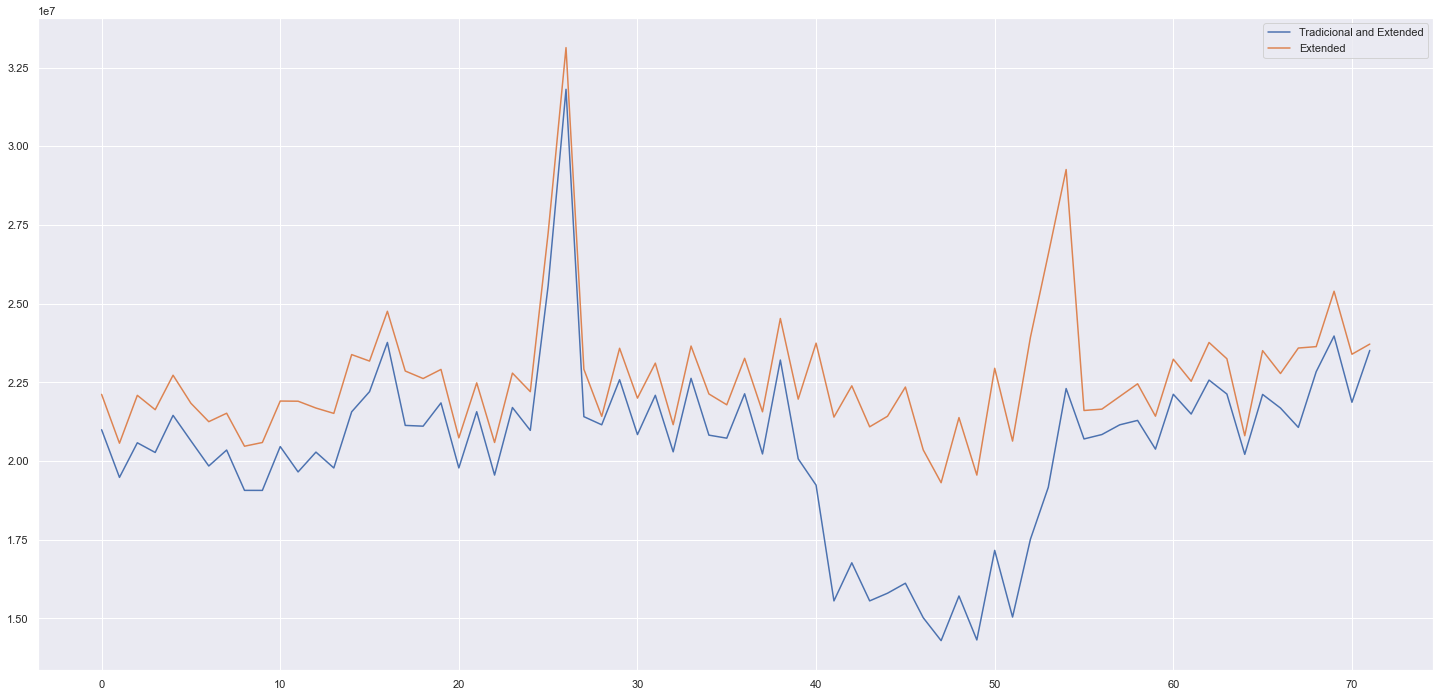

In [42]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional and Extended', 'Extended'])

### 5.2.7 H7 - Should stores open during Christmas sell more?
**False** Because stores sells less

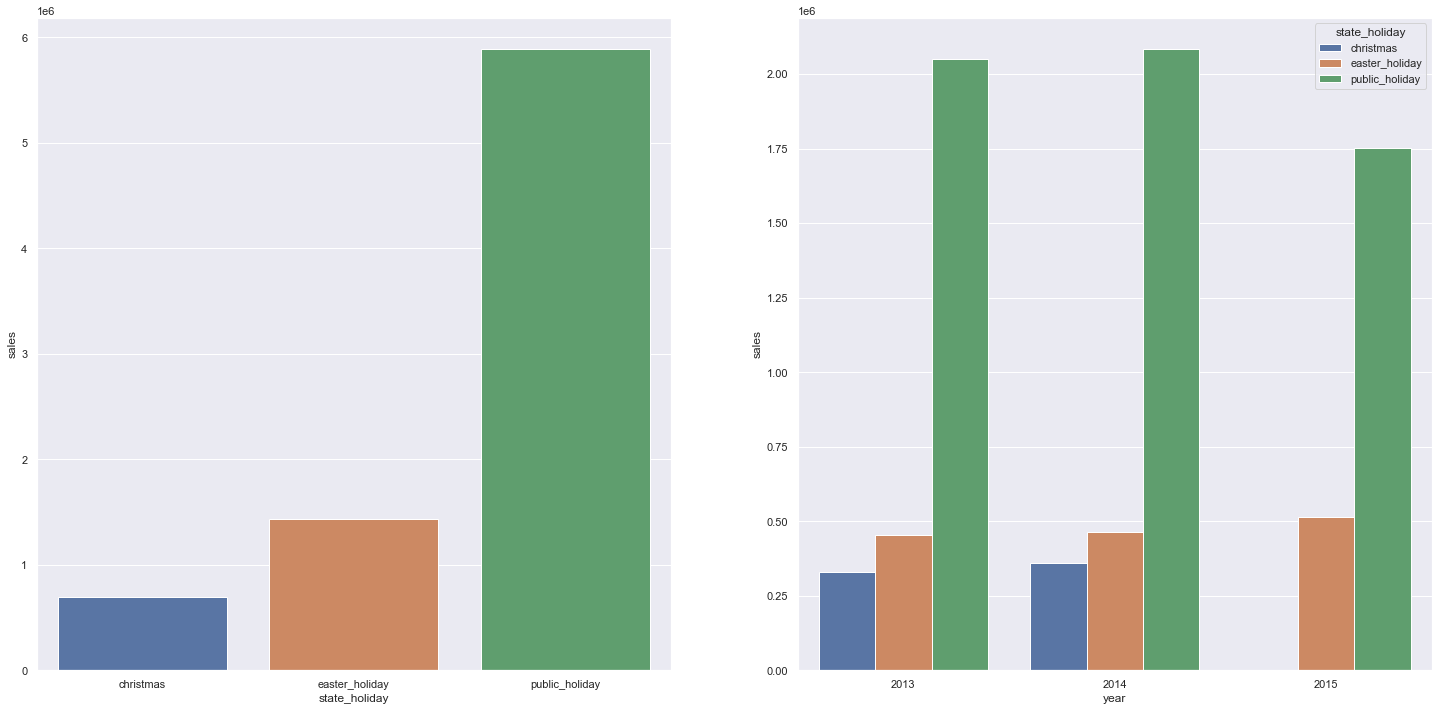

In [43]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### 5.2.8 H8 - Should stores sell more over the years?
**False** Stores sells less over the years

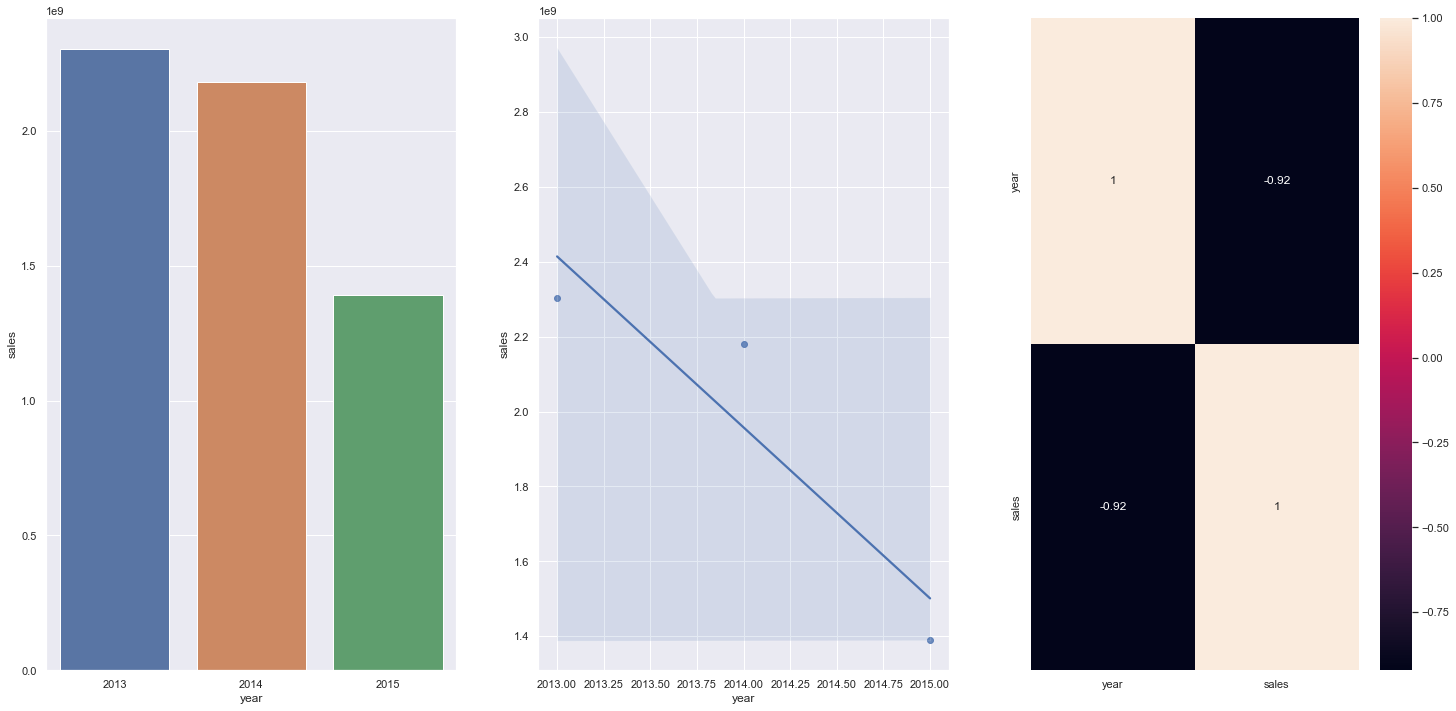

In [44]:
aux1= df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);



### 5.2.9 H9 - Should stores sell more in the second half of the year?
**False** Stores sells less in the second half of the year.

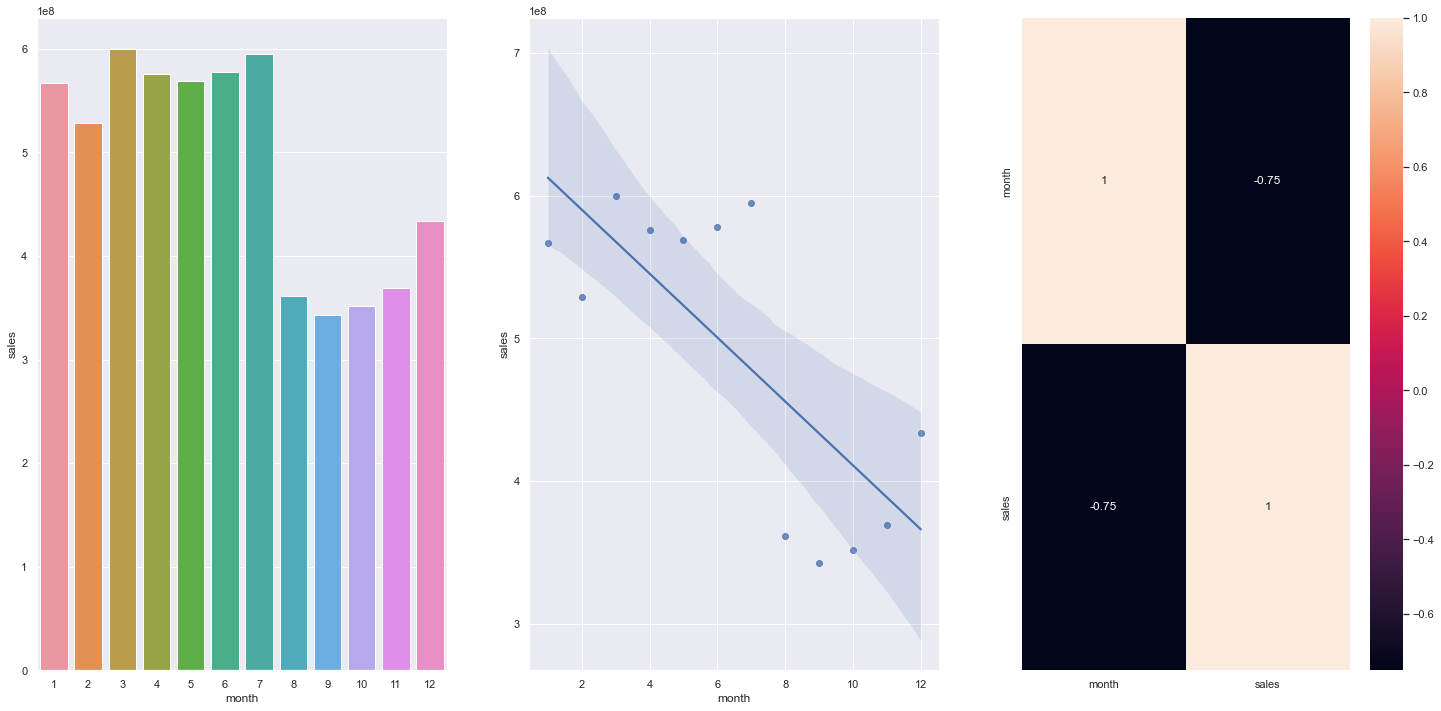

In [45]:
aux1= df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 5.2.10 H10 - Should stores sell more after the 10th of each month?
**True**  

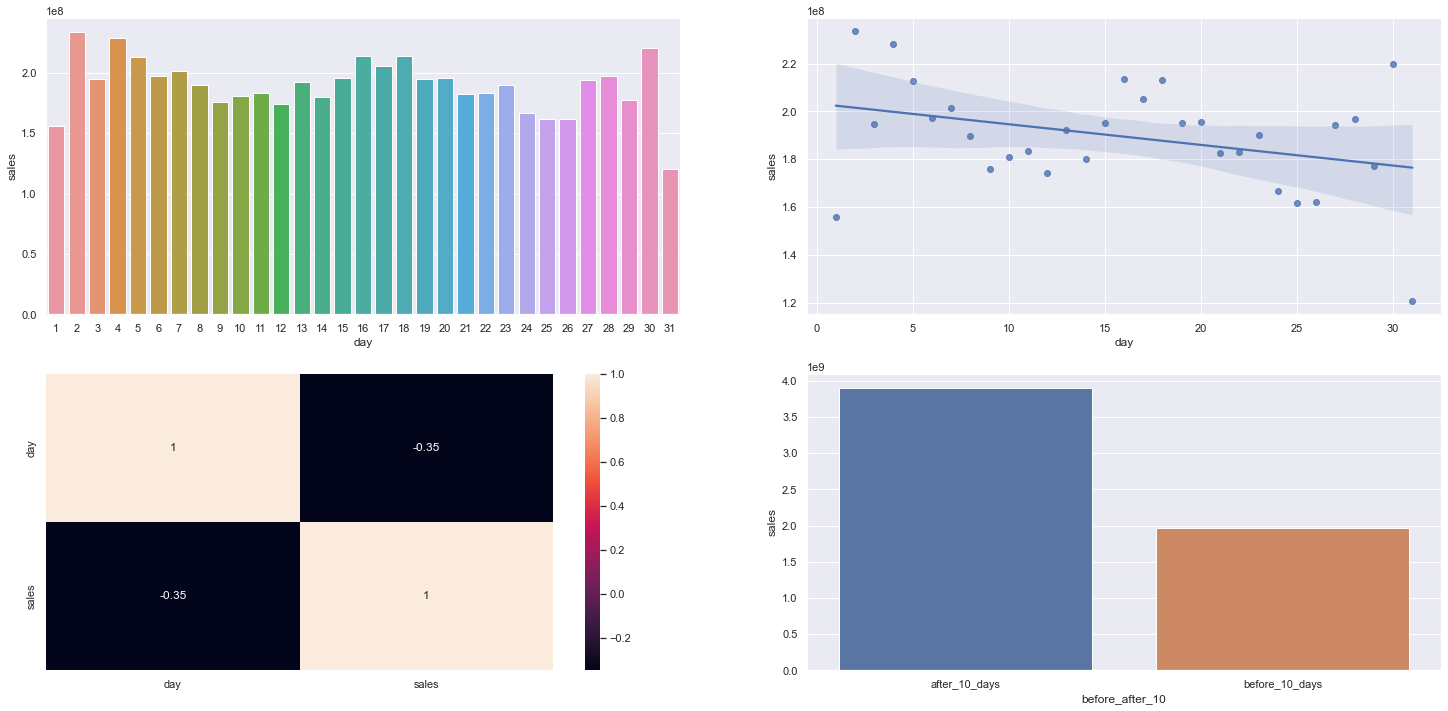

In [46]:
aux1= df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after_10'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after_10', 'sales']].groupby('before_after_10').sum().reset_index()
sns.barplot(x='before_after_10', y='sales', data=aux2);

### 5.2.11 H11 - Should stores sell less on weekends?
**True**

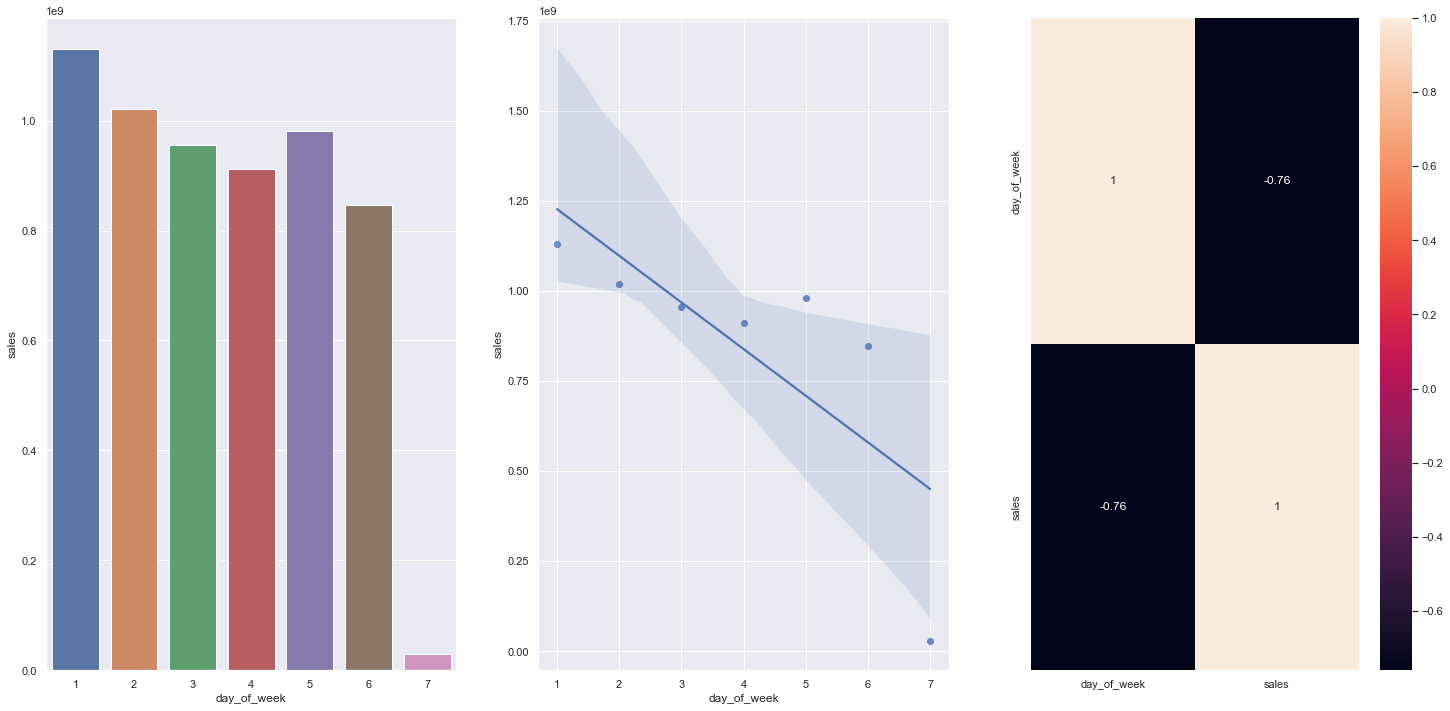

In [47]:
aux1= df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 5.2.12 H12 - Should stores sell less during school holidays?
**True**

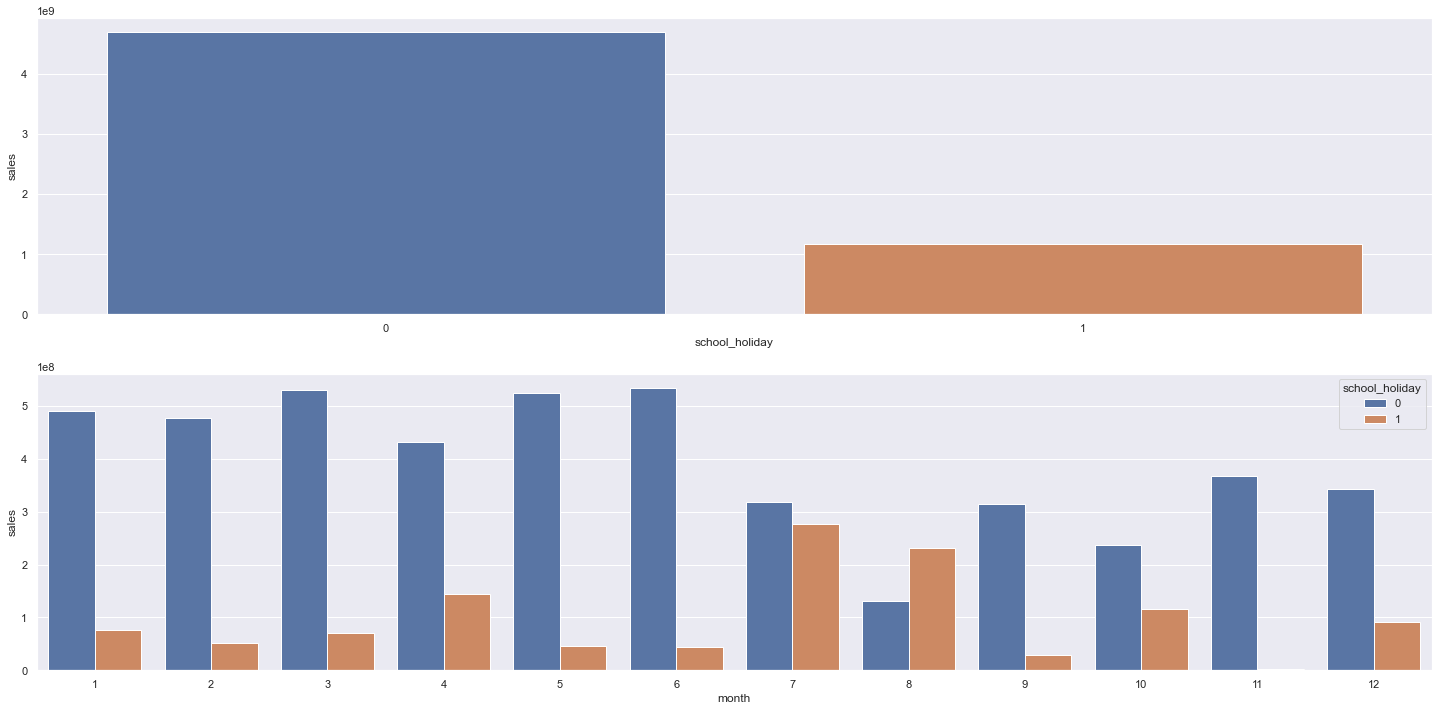

In [48]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 5.2.13 Resume of hypothesis

In [49]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Low'],
      ['H2', 'False', 'Medium'],
      ['H3', 'False', 'Medium'],
      ['H4', 'False', 'Low'],
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'False', 'Medium'],
      ['H8', 'False', 'High'],
      ['H9', 'False', 'High'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'Low']]
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 5.3 Analisys Multivariate

### 5.3.1 Numerical Attributes

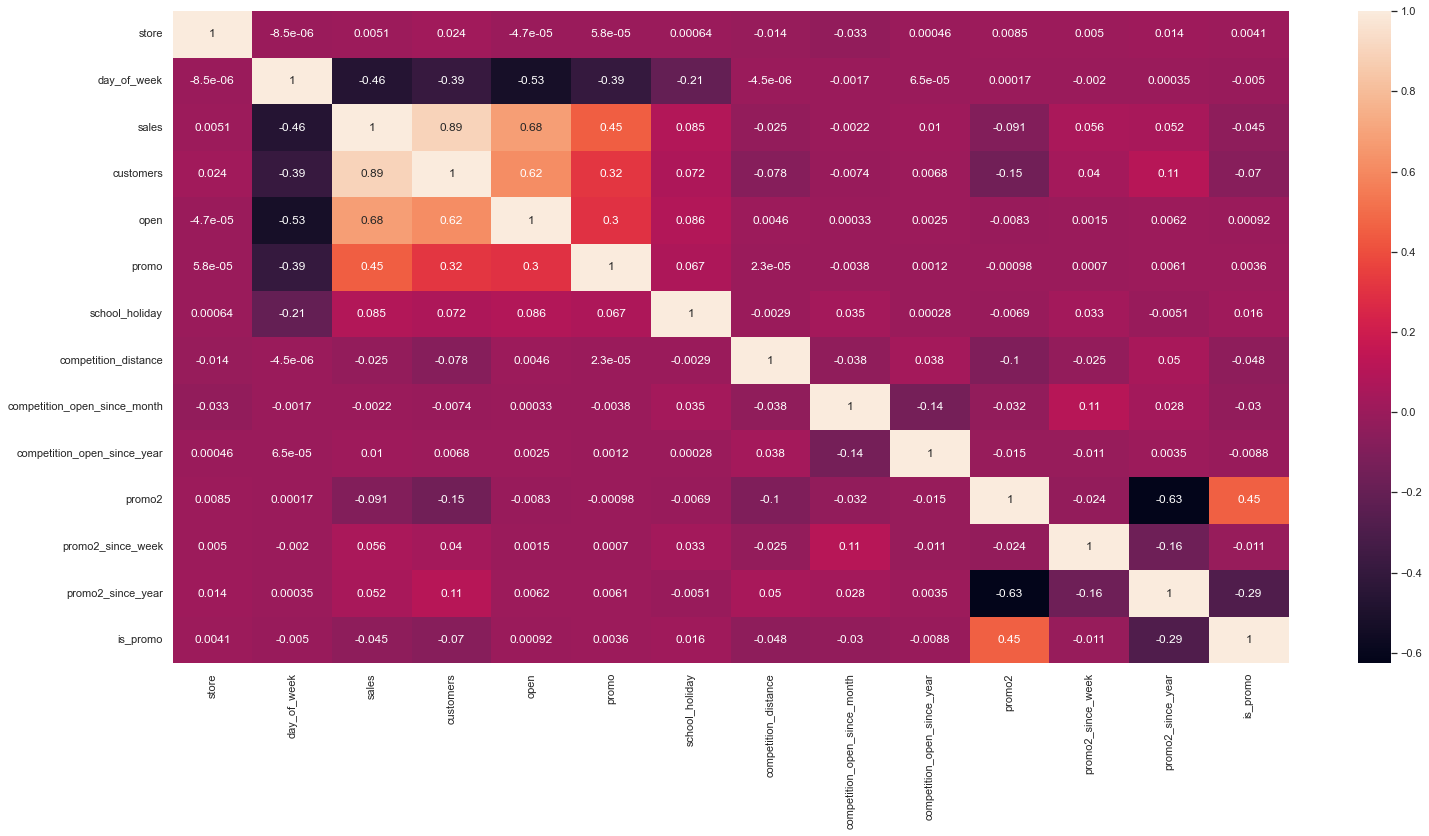

In [50]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 5.3.2 Categorical Attributes

In [51]:
#only categorical data
cat_attrib = df4.select_dtypes(include='object')

In [52]:
#Calculating cramer_V
a1 = cramer_v(cat_attrib['state_holiday'], cat_attrib['state_holiday'])
a2 = cramer_v(cat_attrib['state_holiday'], cat_attrib['store_type'])
a3 = cramer_v(cat_attrib['state_holiday'], cat_attrib['assortment'])

a4 = cramer_v(cat_attrib['store_type'], cat_attrib['state_holiday'])
a5 = cramer_v(cat_attrib['store_type'], cat_attrib['store_type'])
a6 = cramer_v(cat_attrib['store_type'], cat_attrib['assortment'])

a7 = cramer_v(cat_attrib['assortment'], cat_attrib['state_holiday'])
a8 = cramer_v(cat_attrib['assortment'], cat_attrib['store_type'])
a9 = cramer_v(cat_attrib['assortment'], cat_attrib['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
             'store_type': [a4, a5, a6],
             'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)
d
                

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

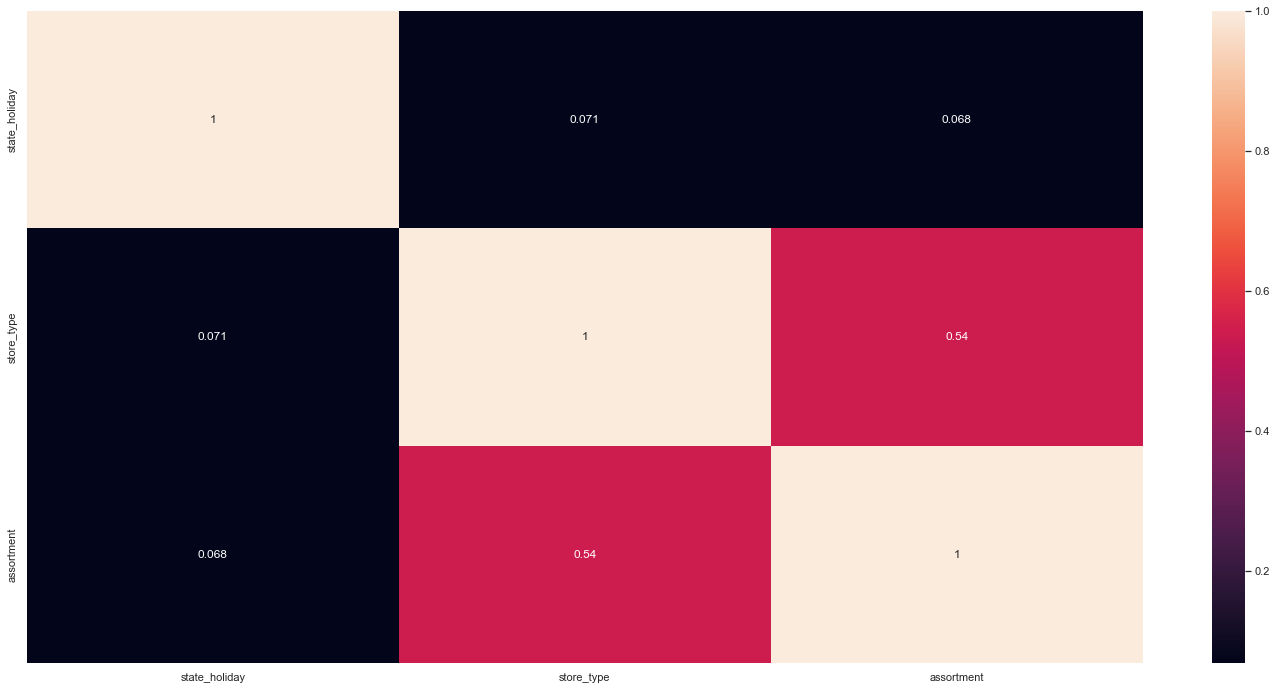

In [53]:
sns.heatmap(d, annot=True)

# 6. Data Preparation

In [30]:
df5 = df4.copy()

## 6.1 Normalization

No variable with normal distribution

## 6.2 Rescalling

In [31]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [56]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance (Robust Scaler)
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))
#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_minmaxscaler.pkl', 'wb'))

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))


#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_minmaxscaler.pkl', 'wb'))



## 6.3 Transformation

### 6.3.1 Encoding

In [33]:
#state_holiday (One Hot Encoding)
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [40]:
#store_type (Label Encoding)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

In [35]:
#assortment (Ordinal Encoding)
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 6.3.2 Response Variable Transformation

<AxesSubplot:xlabel='sales', ylabel='Density'>

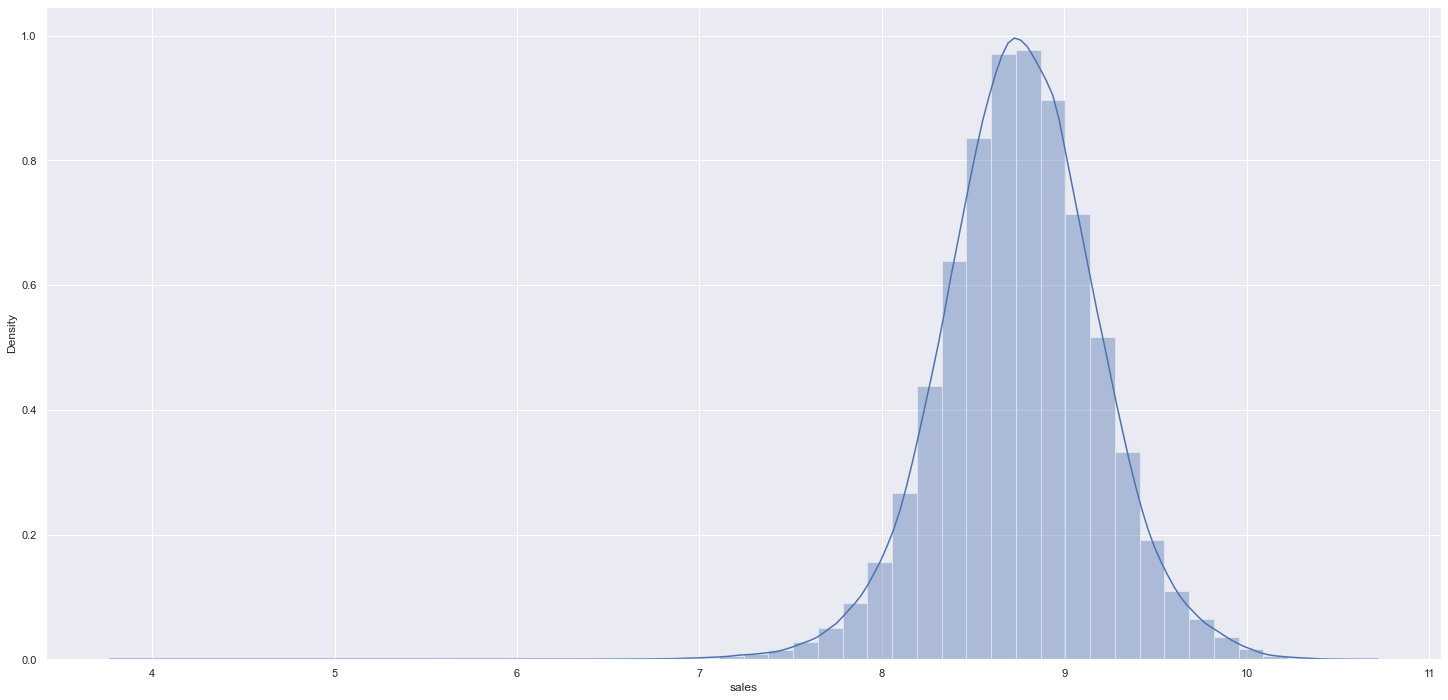

In [36]:
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales'])

### 6.3.3 Nature Transformation

In [37]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2 * np.pi / 7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2 * np.pi / 12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2 * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2 * np.pi / 30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2 * np.pi / 52)))



# 7. Feature Selection

In [42]:
df6 = df5.copy()           

## 7.1 Split dataframe into train and test data

In [43]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6.drop(cols_drop, axis=1, inplace=True)

In [44]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [45]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 7.2 Boruta as Feature Selection

In [98]:
#training and test dataset for Boruta


X_train_n = X_train.drop(['date', 'sales'], axis=1).values
Y_train_n = Y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 7.2.1 Best Features from Boruta

In [99]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [100]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [101]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 7.3 Manual Feature Selection

In [46]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_cos',
                        'month_sin',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']

#columns to add
feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 8. Machine learning Modelling

In [47]:
x_train =  X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 8.1 Average Model

In [112]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#perfomace
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result
                    

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 8.2 Linear Regression Model

In [117]:
#model
lr = LinearRegression().fit(x_train, Y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 8.2.1 Linear Regression Model - Cross Validation

In [170]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 8.3 Linear Regression Regularized Model - Lasso

In [119]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704879,0.289106,2744.451735


### 8.3.1 Lasso - Cross validation

In [171]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 8.4 Random Forest Regressor 

In [122]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.89403,0.09983,1009.811279


### 8.4.1 Random Forest Regressor - Cross Validation

In [172]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number 5

KFold Number 4

KFold Number 3

KFold Number 2

KFold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.97 +/- 217.88,0.12 +/- 0.02,1254.84 +/- 317.36


## 8.5 XGBoost Regressor

In [128]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, Y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.597244,0.949473,7330.872442


### 8.5.1 XGBoost Regressor - Cross validation

In [174]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number 5

KFold Number 4

KFold Number 3

KFold Number 2

KFold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.07 +/- 588.49,0.95 +/- 0.0,7715.02 +/- 689.26


## 8.6 Compare Model's Performance

### 8.6.1 Single Performance

In [127]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.894030,0.099830,1009.811279
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704879,0.289106,2744.451735
0,XGBoost Regressor,6683.606400,0.949503,7330.742181


### 8.6.2 Real Performance

In [176]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.97 +/- 217.88,0.12 +/- 0.02,1254.84 +/- 317.36
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7049.07 +/- 588.49,0.95 +/- 0.0,7715.02 +/- 689.26


# 9. Hyperparameter Fine Tuning

## 9.1 Random Search

In [55]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15]
        }
MAX_EVAL = 10

In [56]:
final_result = pd.DataFrame()
for i in range(MAX_EVAL):
    #choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0]for k, v in param.items()}
    print(hp)
    #model

    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])
    

    #performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1459.25 +/- 165.58,0.2 +/- 0.01,2105.05 +/- 211.89
0,XGBoost Regressor,1639.85 +/- 169.92,0.23 +/- 0.01,2368.42 +/- 220.0
0,XGBoost Regressor,786.91 +/- 112.53,0.11 +/- 0.01,1145.08 +/- 165.9
0,XGBoost Regressor,1065.81 +/- 119.57,0.15 +/- 0.01,1528.71 +/- 167.78
0,XGBoost Regressor,966.12 +/- 131.22,0.14 +/- 0.01,1379.6 +/- 176.63
0,XGBoost Regressor,909.14 +/- 124.83,0.13 +/- 0.01,1313.16 +/- 182.62
0,XGBoost Regressor,1292.69 +/- 142.23,0.18 +/- 0.01,1870.01 +/- 180.47
0,XGBoost Regressor,805.23 +/- 112.27,0.11 +/- 0.01,1159.01 +/- 169.08
0,XGBoost Regressor,780.48 +/- 128.3,0.11 +/- 0.01,1133.28 +/- 193.88
0,XGBoost Regressor,1459.25 +/- 165.58,0.2 +/- 0.01,2105.05 +/- 211.89


## 9.2 Final Model

In [60]:
param_tuned = {'n_estimators': 3500,
        'eta': 0.03,
        'max_depth': 9,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'min_child_weight': 15 
        }

#model

model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=param_tuned['n_estimators'],
                            eta=param_tuned['eta'],
                            max_depth=param_tuned['max_depth'],
                            subsample=param_tuned['subsample'],
                            colsample_bytree=param_tuned['colsample_bytree'],
                            min_child_weight=param_tuned['min_child_weight']).fit(x_train, Y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)



NameError: name 'y_test' is not defined

In [61]:
#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,611.028552,0.088598,900.348493


In [62]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [64]:
#Saving model

import pickle

filename = 'rossmann_model_xgb.sav'
pickle.dump(model_xgb_tuned, open(filename, 'wb'))

# 10. Error Interpretation 

In [65]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 10.1 Business Performance

In [68]:
#sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})
#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [69]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104541.25000,101231.265561,107851.234439,3309.984439,0.548746
908,909,238339.56250,230755.814198,245923.310802,7583.748302,0.519436
875,876,200532.28125,196543.937935,204520.624565,3988.343315,0.297442
594,595,378089.03125,374004.599675,382173.462825,4084.431575,0.279731
721,722,346181.40625,344373.692924,347989.119576,1807.713326,0.244367


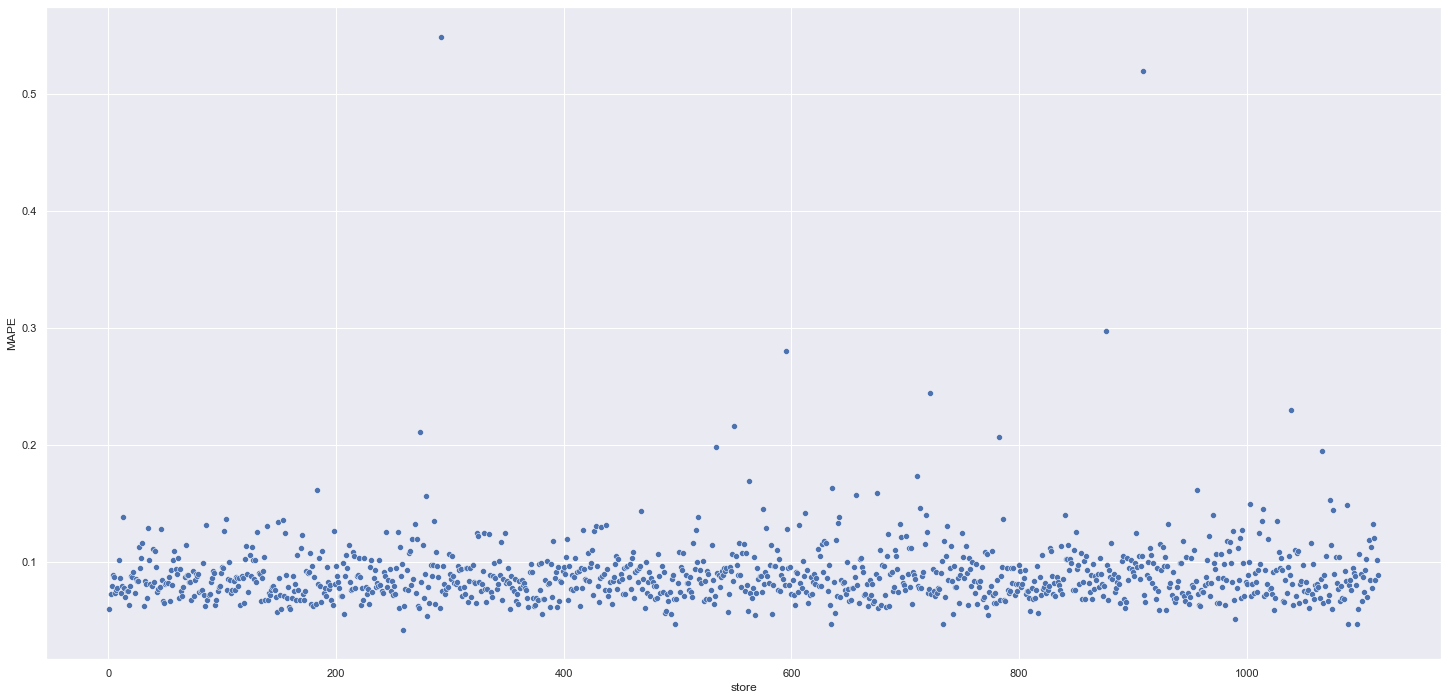

In [70]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 10.2 Total Performance

In [73]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"$284,330,496.00"
1,worst_scenario,"$283,644,959.61"
2,best_scenario,"$285,016,064.52"


## 10.3 Machine Learning Perfomance

In [75]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

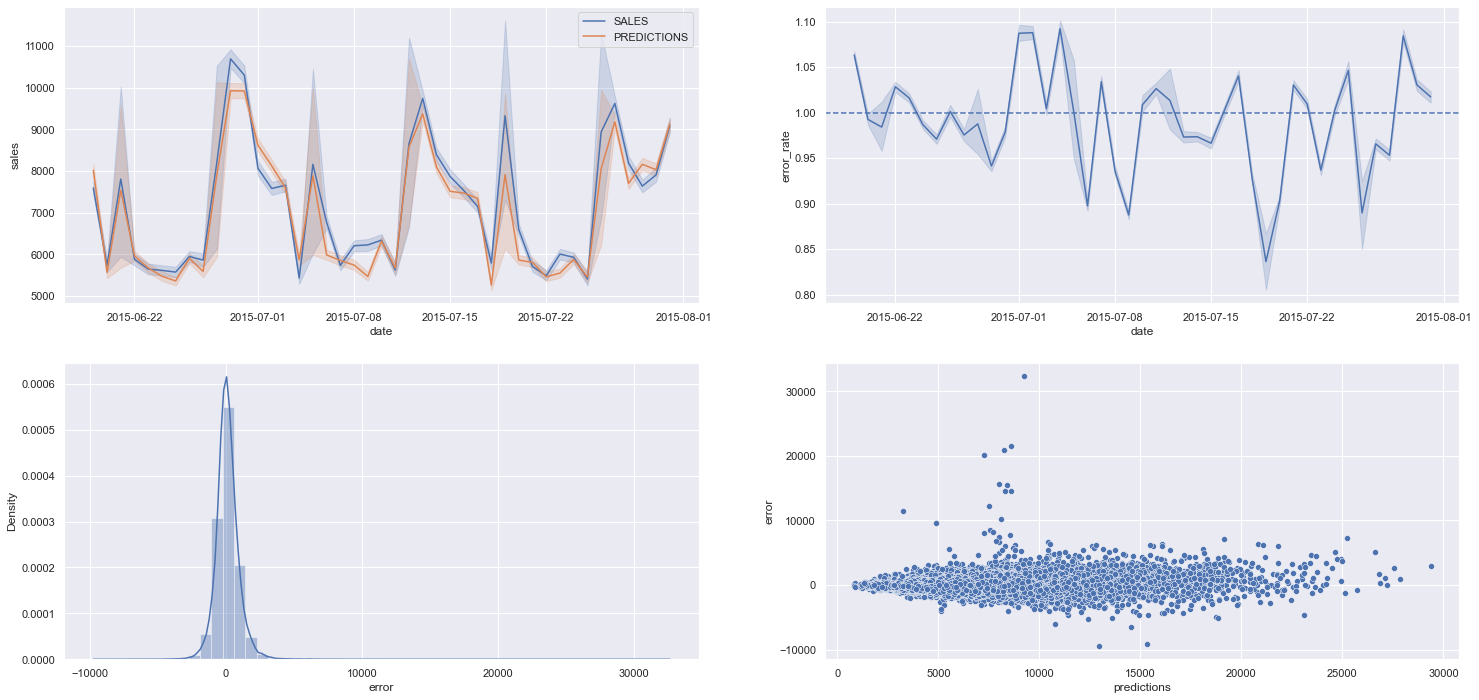

In [76]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error']);